### Application Note: tomtom-lite

In this notebook, we will reproduce the analyses and figures in the tomtom-lite application note. Most of the computation will be done in scripts that save results out to disk, which can be found in the paper directory of the GitHub repo. This notebook will load those results, compute important values from them, and ultimately plot the figures before they are edited and composed.

In [1]:
import matplotlib
matplotlib.use('pdf')

%matplotlib inline
from matplotlib import pyplot as plt

import seaborn; seaborn.set_style('whitegrid')
import numpy

#### P-value comparison

The first comparison that we do between Tomtom and Tomtom-lite is between the p-values when comparing all of JASPAR 2024 against itself. The results from the two methods are fairly different. Tomtom produces a text file that is already sorted, whereas tomtom-lite produces a numpy array that is a square matrix where the motif indexes correspond to the row and column indexes. We can take a look at the Tomtom output before we do anything with it.

In [2]:
import pandas

t_df = pandas.read_csv(".tomtom.jaspar", sep="\t", comment='#')
t_df.head()

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation
0,0,0,0,7.948030e-31,1.866200e-27,3.553670e-27,10,ACCATATGTT,ACCATATGTT,+
1,0,131,0,1.069500e-07,2.511190e-04,1.593960e-04,10,ACCATATGTT,AACATATGTT,-
2,0,142,0,2.198130e-07,5.161210e-04,1.948640e-04,10,ACCATATGTT,GACATATGTC,-
3,0,121,0,4.335330e-07,1.017940e-03,2.536140e-04,10,ACCATATGTT,GACATATGTT,-
4,0,155,0,5.105030e-07,1.198660e-03,2.536140e-04,10,ACCATATGTT,ACCATATGGT,+


Next, we can load up the tomtom-lite output and look at the shape and range of values.

In [3]:
m_npy = numpy.load("tomtom.jaspar.scores.npy")[0]
m_npy.shape, m_npy.min(), m_npy.max()

((2348, 2348), -2.5228708011582057e-12, 1.0)

Finally, we can make a new square matrix for the Tomtom p-values and iterate through the text file. Each row will have one entry in this matrix, where Query_ID encodes the row index and Target_ID encodes the column index. As an additional check we can initially set this entire square matrix to NaN and then count the number of NaNs at the end. If it is non-zero, something has gone wrong.

In [4]:
t_npy = numpy.zeros_like(m_npy) + numpy.nan
t_npy[t_df['Query_ID'], t_df['Target_ID']] = t_df['p-value']
numpy.isnan(t_npy).sum()

0

Before we work with this matrix we need to account for one issue: the diagonal of these p-values will be basically machine precision, because a PWM is identical to itself. This can cause an issue with Pearson correlation because these values can be outliers compared to the normal distribution of p-values and also likely not strongly agreeing between the two implementations simply because Tomtom uses 64-bit floats and tomtom-lite uses 32-bit floats. To circumvent this issue, we will add 1 to the entire diagonal and also add an epsilon term derived from the machine precision of 32-bit floats. This will reduce the effect of those two issues while retaining that both implements agree that self-comparisons yield similar values.

In [5]:
m_npy += numpy.eye(m_npy.shape[0])
t_npy += numpy.eye(m_npy.shape[0])

eps = numpy.finfo('float32').eps

p0 = t_npy.flatten() + eps
p1 = m_npy.flatten() + eps

Now, we can calculate the Pearson correlation between the two.

In [6]:
numpy.corrcoef(
    numpy.log(p0), 
    numpy.log(p1)
)[0, 1]

0.9998832446422593

Looks high. Let's plot the figure that is Fig1B in the Application Note.

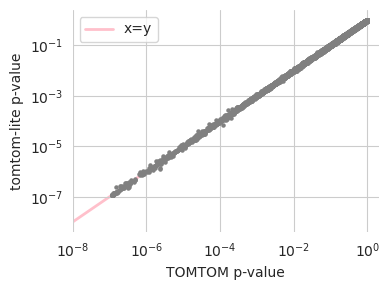

In [7]:
plt.figure(figsize=(4, 3))

plt.scatter(p0[::100], p1[::100], s=5, color='0.5')
plt.plot([1e-8, 1], [1e-8, 1], linewidth=2, c='pink', zorder=-1, label="x=y")

plt.legend()
plt.xlim(1e-8, 2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("TOMTOM p-value")
plt.ylabel("tomtom-lite p-value")
seaborn.despine(bottom=True, left=True)
plt.tight_layout()
#plt.savefig('fig1-accuracy.pdf')
plt.show()

Seems like there is a pretty strong correlation. But, perhaps more importantly, it seems like the points on the top right are closer to the x=y line than those that are closer to the middle of the plot. This makes sense because the influence of the approximations in tomtom-lite will be stronger when the p-values are low than when they are high. What percentage of all points is that?

In [8]:
idx0 = p0 > 1e-3
idx1 = p0 <= 1e-3

idx0.mean(), idx1.mean()

(0.9821108036416508, 0.017889196358349128)

Looks like 98.2% of all points are in that are closer to the x=y line. What are the correlations in these two regimes?

In [9]:
r0 = numpy.corrcoef(
    numpy.log(p0[idx0]), 
    numpy.log(p1[idx0])
)[0, 1]

r1 = numpy.corrcoef(
    numpy.log(p0[idx1]), 
    numpy.log(p1[idx1])
)[0, 1]

r0, r1

(0.999833872075166, 0.9990210302902295)

Looks pretty high, with the p-values being almost identical when they are greater then 1e-3 and pretty similar -- although not identical -- below that. The main take-away for me here is that tomtom-lite is an almost-perfect reproduction of the original tomtom p-values when the task is discriminative in nature, e.g., distinguishing those that are good matches from those that are not, but that there may be a more noticable effect when one wants to know exactly what the best match is and distinguish it from other good matches.

#### Timings

Now, let's turn to the first of the timings. Here, we will compare an increasing number of queries against the entire JASPAR 2024 motif database. Our comparisons will include running the original TOMTOM tool, as well as running tomtom-lite with an increasing number of threads.

/tmp/ipykernel_9062/4144113518.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, times_q[i], s=20, c=colors[i])


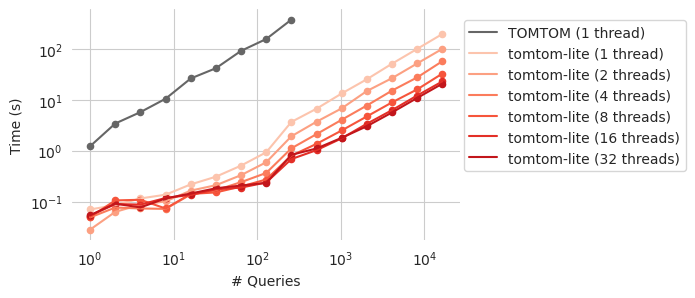

In [10]:
times_q = numpy.load("tomtom.times.q.npy")
x = 2**numpy.arange(16)[:times_q.shape[1]]


labels = ["TOMTOM (1 thread)", "tomtom-lite (1 thread)"]
labels += ["tomtom-lite ({} threads)".format(i) for i in [2, 4, 8, 16, 32]]
colors = ['0.4'] + [seaborn.color_palette('Reds', 8)[i+1] for i in range(6)]


plt.figure(figsize=(5, 3))

for i in range(7):
    plt.plot(x, times_q[i], label=labels[i], c=colors[i])
    plt.scatter(x, times_q[i], s=20, c=colors[i]) 
                
                
plt.legend(loc=(1.01, 0.3))
seaborn.despine(bottom=True, left=True)
plt.yscale('log')
plt.xscale('log')
plt.xlabel("# Queries")
plt.ylabel("Time (s)")
plt.savefig("fig1-jaspar-timings.pdf")
plt.show()

Looks like both scale linearly in time with the number of queries but that tomtom-lite is significantly faster and also that additional threads seems to help.

Let's get a ratio for how much faster tomtom-lite is than TOMTOM across the range of number of queries, comparing using only one thread and also using 32 threads.

In [11]:
times_q[0] / times_q[1], times_q[0] / times_q[-1]

(array([ 17.50670558,  40.445873  ,  49.9503327 ,  77.19219514,
        121.35420629, 136.23636567, 181.03394661, 169.38409251,
        102.93471983,          nan,          nan,          nan,
                 nan,          nan,          nan]),
 array([ 22.70198617,  37.73049392,  75.03004887,  91.2969393 ,
        183.47998223, 229.72969385, 446.89560116, 676.13427923,
        457.2122408 ,          nan,          nan,          nan,
                 nan,          nan,          nan]))

Looks like we are going from 17.5x faster 181x faster at it's peak when going from 1 query to 64 queries with one thread, and from 22.7x faster to 676x faster when using 32 threads. That's quite an improvement! However, it seems like the marginal gain of using additional threads diminishes quite a bit after using 8 threads. This can happen when each task is fast compared to the communication overhead of completing these tasks. Since each task in our case is one query and mapping each query to the target database is pretty fast (less than one second usually), the communication overhead being the bottleneck can happen particularly quickly and will, ironically, get worse the better the implementation gets in the future. A potential (yet unrealized) solution is to divide all of the queries into blocks and treat each block as an individual task. Something for the future.

To confirm that this is the case, we can increase the complexity of the task and see whether parallelism scales better. Basically, if we increase the time it takes to map each query to the target database, the communication cost will be a relatively smaller component. A simple way to do this is to create a synthetic target database made up of 1 million randomly generated PWMs that are of length 15. This increases the number of targets, decreases the redundancy amongst columns, and also the additional positions increase the amount of necessary compute.

/tmp/ipykernel_9062/572561351.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, times_r[i], s=20, c=colors[i+1])


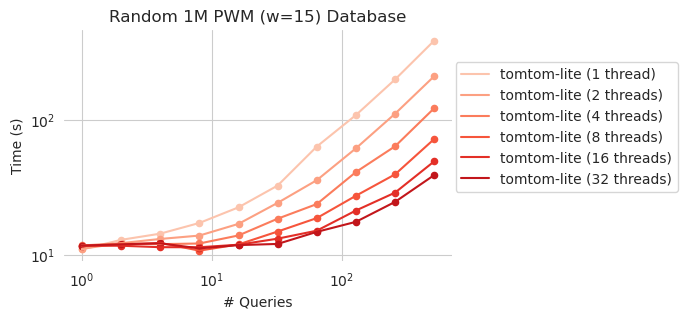

In [12]:
times_r = numpy.load("tomtom.times.r.npy") 

x = 2**numpy.arange(15)[:times_r.shape[1]]


plt.figure(figsize=(5, 3))
plt.title("Random 1M PWM (w=15) Database")
for i in range(6):
    plt.plot(x, times_r[i], label=labels[i+1], c=colors[i+1])
    plt.scatter(x, times_r[i], s=20, c=colors[i+1]) 
                
                
plt.legend(loc=(1.01, 0.3))
seaborn.despine(bottom=True, left=True)
plt.yscale('log')
plt.xscale('log')
plt.xlabel("# Queries")
plt.ylabel("Time (s)")
plt.savefig('fig1-timings-random.pdf')
plt.show()

Looks like we see much better scaling here up to even 32 threads as we increase the number of queries. That being said, we are starting to see diminished gains at that point, suggesting that even a target database of 1M examples is not particularly computationally challenging.

As our next timing evaluation, we can consider the time it takes to map the same number of queries to a target database of increasing size.

/tmp/ipykernel_9062/557300929.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, times_t[i], s=20, c=colors[i])


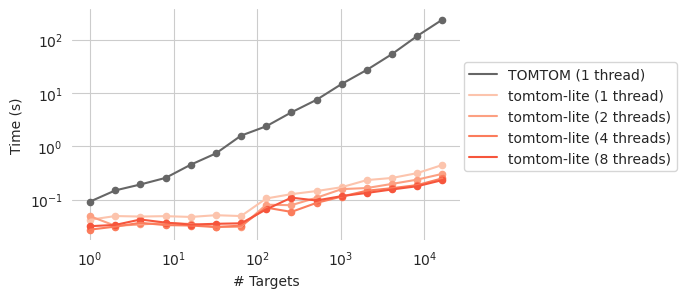

In [13]:
times_t = numpy.load("tomtom.times.t.npy") 

x = 2 ** numpy.arange(15)


plt.figure(figsize=(5, 3))
for i in range(5):
    plt.plot(x, times_t[i], label=labels[i], c=colors[i])
    plt.scatter(x, times_t[i], s=20, c=colors[i]) 
                
                
plt.legend(loc=(1.01, 0.3))
seaborn.despine(bottom=True, left=True)
plt.yscale('log')
plt.xscale('log')
plt.xlabel("# Targets")
plt.ylabel("Time (s)")
plt.savefig('fig1-timings-t.pdf')
plt.show()

Looks like the scaling is much better here than it is for the number of queries. This is due, in part, to the re-use of background distributions across targets. Because the calculation of background distributions is still sometimes the compute bottleneck in tomtom-lite, despite their caching and recursive calculation, it must be particularly bad for TOMTOM.

As before, we can look at how many times faster tomtom-lite is than TOMTOM across number of threads and targets.

In [14]:
times_t[0] / times_t[1], times_t[0] / times_t[-1]

(array([  2.18926536,   3.02286181,   3.9899565 ,   5.21054575,
          9.52743891,  14.38533889,  32.1492395 ,  22.52980956,
         34.05450933,  51.24433688,  85.98711581, 116.20271989,
        209.45374344, 370.96725982, 528.90823527]),
 array([   2.89410567,    4.43356859,    4.53263272,    6.87913951,
          13.23732693,   20.83757364,   43.95868013,   36.05517268,
          39.66619927,   76.93135265,  126.34703578,  202.20958589,
         344.11203923,  653.00180308, 1015.74278606]))

#### Target Hashing

A potential question is the number of bins needed for the hashing of target columns. As a reminder, this hashing is done by binning each value into a user-specified number of bins and merging columns only if there is a match on every position in the column. For a column with four elements, e.g. DNA, this means that there are 100^4 possible hashes. But is 100 enough.. is it too many? Naturally, decreasing the number of bins can increase speed by removing more computations, but that will also influence the quality of the results. The answer seems to be that it depends on the size of the target database.

/tmp/ipykernel_9062/527754371.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, times_b[i], c=colors[i], s=10)


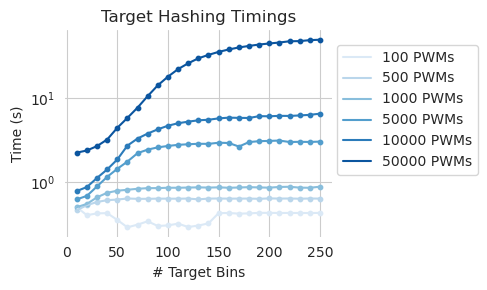

In [15]:
times_b = numpy.load("tomtom.times.t_bins.npy")

x = range(10, 251, 10)
n_pwms = [100, 500, 1000, 5000, 10000, 50000]

colors = seaborn.color_palette("Blues", 6)

plt.figure(figsize=(5, 3))
plt.title("Target Hashing Timings")
for i, n_pwms in enumerate(n_pwms):
    plt.plot(x, times_b[i], label="{} PWMs".format(n_pwms), c=colors[i])
    plt.scatter(x, times_b[i], c=colors[i], s=10)
    

plt.legend(loc=(1.02, 0.3))

seaborn.despine(bottom=True, left=True)
plt.xlabel("# Target Bins")
plt.ylabel("Time (s)")
plt.yscale('log')
plt.tight_layout()
plt.savefig("fig1-timings-hash.pdf")
plt.show()

Here, we compare the amount of time it takes to run tomtom-lite with the same number of queries against target databases of differing sizes (the colorings) and with differing numbers of target bins (the x-axis). The main take-away is that there is a sigmoid pattern that levels off at increasing number of bins as the number of PWMs gets larger. The default choice of 100 bins is at this maximum value for most database sizes, but once we get to over 50,000 PWMs it is within the linear part of the sigmoid.

tl;dr, if you have a particularly large PWM database you may want to increase the number of bins or at least check how different the p-values are for a test run.

#### Applications: Real-time Annotation

Our first application of tomtom-lite is to real-time annotation of seqlets. In this setting, we are interactively considering the attributions from a ChromBPNet model and want to knoww what those contiguous spans of high attribution correspond to! Having to wait several additional seconds for the annotation process is annoying and can be a source of friction (see https://tangermeme.readthedocs.io/en/latest/howto/How_To_-_Reduce_Friction_and_Save_Time_with_Tangermeme.html for more thoughts on reducing friction).

Let's start off by loading a publicly-available ChromBPNet model using the bpnet-lite repository and slicing out only the count head.

In [16]:
from bpnetlite import BPNet
from bpnetlite.bpnet import CountWrapper

chrombpnet = BPNet.from_chrombpnet("../../../models/chrombpnet/fold_0/model.chrombpnet_nobias.fold_0.ENCSR868FGK.h5")
chrombpnet = CountWrapper(chrombpnet)

Next, we can load up the element of interest that we may be applying ChromBPNet to.

In [17]:
import pyfaidx
from tangermeme.io import one_hot_encode

chrom, start, end = 'chr3', 128481848, 128493691
mid = (start + end) // 2
start, end = mid - 1057, mid + 1057

X = pyfaidx.Fasta("../../../common/hg38.fa")[chrom][start:end].seq.upper()
X = one_hot_encode(X)[None].float()
X.shape

torch.Size([1, 4, 2114])

Then, we can run DeepLIFT to calculate attributions for ChromBPNet at this locus.

In [18]:
from tangermeme.deep_lift_shap import deep_lift_shap

X_attr = deep_lift_shap(chrombpnet, X, random_state=0)
X_attr.shape

torch.Size([1, 4, 2114])

Given attribution scores, we can automatically identify those contiguous spans of high attribution called seqlets.

In [19]:
from tangermeme.seqlet import recursive_seqlets

seqlets = recursive_seqlets(X_attr.sum(axis=1), additional_flanks=2)
seqlets

,example_idx,start,end,attribution,p-value
0,0,1257,1267,0.265536,0.001007
1,0,1171,1181,-0.063159,0.001800
2,0,1294,1302,0.172060,0.004008
3,0,1309,1317,-0.025179,0.007266


Looks like our procedure identified four seqlets. Finally, we can plot the attributions with the seqlets annotated below them.

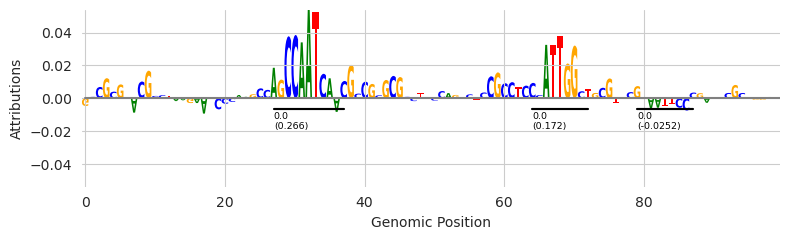

In [20]:
from tangermeme.plot import plot_logo

plt.figure(figsize=(8, 2.5))
plot_logo(X_attr[0], start=1230, end=1330, annotations=seqlets, score_key='attribution')
plt.plot([0, 100], [0, 0], c='0.5')

plt.ylabel("Attributions")
plt.xlabel("Genomic Position")
plt.tight_layout()
plt.savefig("fig1-attributions.pdf")
plt.show()

A challenge here is that we can see the seqlets but, without domain knowledge or several years of staring at a motif database, we might not know what these spans correspond to (or even which exact nucleotides may be relevant).

We can use tomtom-lite to annotate these sequences by running the discrete sequence within each seqlet against the JASPAR 2024 motif database.

In [21]:
import time

from tangermeme.io import read_meme
from tangermeme.annotate import annotate_seqlets

motifs = read_meme("JASPAR2024_CORE_non-redundant_pfms_meme.txt")
motif_names = numpy.array([motif.split()[1] for motif in motifs])

tic = time.time()
motif_idxs, motif_pvals = annotate_seqlets(X, seqlets, motifs)
print(time.time() - tic)

0.09505748748779297


Looks like it took roughly 0.1 seconds to map those four seqlets. As a side note, we can pass the string of the database directly into the `annotate_seqlets` function, removing three lines from this block, but we need the name of the motifs later and need to remove the JASPAR ID that is the first word in those names for legibility.

In [22]:
import os
from memelite.io import write_meme

X_seqlets = [X[0, :, s:e].numpy() for s, e in seqlets[['start', 'end']].values]
write_meme("seqlets.X.meme", X_seqlets)

tic = time.time()
os.system("tomtom seqlets.X.meme JASPAR2024_CORE_non-redundant_pfms_meme.txt -motif-pseudo 0 -thresh 1 -text -verbosity 1 > .seqlets.tomtom")
print(time.time() - tic)

2.4819419384002686


In contrast to the ~0.1 seconds above, it takes ~2.5 seconds to run TOMTOM. Although 2.5 seconds is not a lot of time, it is an annoying source of friction to have to wait several seconds each time you want to visualize a locus. These sources of friction can easily build up and make interactive exploration more challenging. Further, this will get worse in sequences that are more dense with seqlets.

Finally, we can visualize our annotated seqlets and immediately see what is happening at the locus.

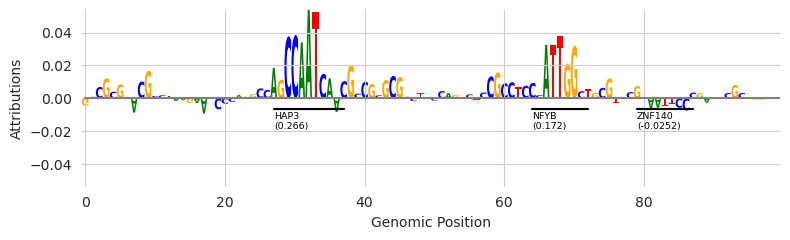

In [23]:
seqlets['example_idx'] = motif_names[motif_idxs]
seqlets.head()

plt.figure(figsize=(8, 2.5))
plot_logo(X_attr[0], start=1230, end=1330, annotations=seqlets, score_key='attribution')
plt.plot([0, 100], [0, 0], c='0.5')

plt.ylabel("Attributions")
plt.xlabel("Genomic Position")
plt.tight_layout()
plt.savefig("fig1-attributions.pdf")
plt.show()

#### Applications: Large-scale Annotation

Next, we consider a more compute-intensive application where we want to call seqlets on all peaks genome-wide, annotate every seqlet, and then count the number of seqlets that are mapped to each motif in the database. We note that a challenge with doing this sort of analysis with the entire JASPAR database is that -- despite being called non-redundant -- it is actually still fairly redundant with many motifs that are biologically the same thing but just from different experiments. 

We have already pre-computed the attribution scores and done the seqlet calling, as that is a somewhat compute intensive step. We just need to load up those seqlet calls and the sequence in order to do seqlet annotation.

In [24]:
import pandas
from tangermeme.io import extract_loci

X = extract_loci("ENCFF558BLC.bed.gz", "../../../common/hg38.fa", verbose=True).float()
X = X[X.sum(dim=(1, 2)) == 2114]
print(X.shape)

all_seqlets = pandas.read_csv("chrombpnet_seqlets.tsv", sep="\t").sort_values("attribution", ascending=False)
all_seqlets.head()

Loading Loci: 100%|██████████| 203874/203874 [00:13<00:00, 15082.47it/s]


torch.Size([203804, 4, 2114])


,example_idx,start,end,attribution,p-value
48029,99724,1102,1123,3.472462,0.000745
48028,99726,1102,1123,3.472462,0.000745
48030,99725,1102,1123,3.472462,0.000745
33871,74273,1048,1072,2.561029,0.000540
33902,74274,1048,1072,2.561029,0.000540


We can use the same function as before to annotate these seqlets using tomtom-lite.

In [25]:
tic = time.time()
motif_idxs, motif_pvals = annotate_seqlets(X, all_seqlets, motifs)
print(time.time() - tic)

1225.1587882041931


Now, we can simply count the number of times a seqlet was annotated with each motif and plot the top ones.

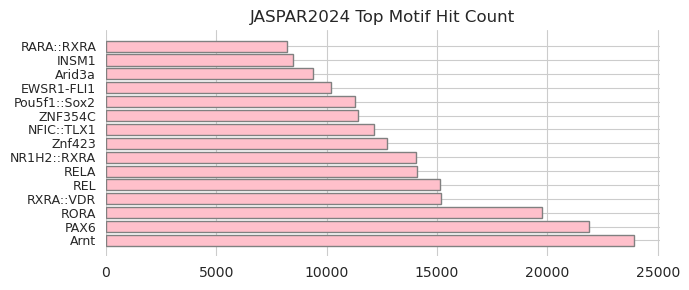

In [26]:
motif_uidxs, motif_counts = numpy.unique(motif_idxs, return_counts=True)

idxs = numpy.argsort(motif_counts)[::-1]
motif_uidxs, motif_counts = motif_uidxs[idxs], motif_counts[idxs]

plt.figure(figsize=(7, 3))
plt.title("JASPAR2024 Top Motif Hit Count")

n = 15

plt.barh(range(n), motif_counts[:n], facecolor='pink', edgecolor='0.5', linewidth=1)
plt.yticks(range(n), motif_names[:n], fontsize=9)

seaborn.despine(bottom=True, left=True)
plt.tight_layout()
plt.savefig('fig1-counts.pdf')
plt.show()